# CellAssign results

Notebook showing cellAssign results with new taxonomy from Nick.

`cell_types` composed in https://github.com/NIH-CARD/brain-taxonomy

```python
cell_types = [
    "oligo", #Oligo
    "opc", #OPC
    "glutamatergic", #ExN
    "gabergic", #InN
    "astrocyte", #Astro
    "immune", #MG
    "blood", #VC
]
```

----


Outline:

- setup:  imports, helper_functions, data path definitions
- get predictions (fit `cellassign` model)
- assess predictions
    - clean vs. full set of samples
    - cellassign "noise" parameter:  `continuous_covariate_keys=["doublet_score", "pct_counts_mt", "pct_counts_rb"]` vs `None`
    - repititions / seeds


## setup  
- imports 
- helper_functions 
- data path definitions

In [1]:
import sys
import os

import scanpy as sc
import anndata as ad
from pathlib import Path
import scipy.sparse as sp
import pandas as pd
import numpy as np
import scvi

# %%
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath(".."))


In [2]:
XYLENA2_RAW_PATH = "data/scdata/xylena_raw"
XYLENA2_PATH = "data/scdata/xylena"

# FULL data is both "clean" (train+test) and "dirty" samples which were originally left out of the dataset
XYLENA2_FULL = "xyl2_full.h5ad"


CELLASSIGN_SIMPLE_MARKERS_TABLE = "cellassign_simple_markers.csv"
CELLASSIGN_SIMPLE2_MARKERS_TABLE = "cellassign_simple2_markers.csv"
CELLASSIGN_SIMPLE3_MARKERS_TABLE = "cellassign_simple3_markers.csv"


In [3]:
root_path = Path.cwd().parent
data_path = root_path / XYLENA2_PATH
raw_data_path = root_path / XYLENA2_RAW_PATH

markers_path = raw_data_path / CELLASSIGN_SIMPLE3_MARKERS_TABLE
markers = pd.read_csv(markers_path, index_col=0)

In [4]:
# helper functions
def get_cell_types(adata, markers, batch_key=None, noise=None, seed=9627):
    """ """
    #  2. copy for cellassign
    # bdata = adata[:, markers.index].copy() #
    bdata = adata[:, adata.var.index.isin(markers.index)].copy()

    #  3. get size_factor and noise .  NOTE: it is imperitive to compute lib_size on the full data
    lib_size = adata.X.sum(1)  # type: ignore
    bdata.obs["size_factor"] = lib_size / np.mean(lib_size)

    #  4. model = CellAssign(bdata, marker_genes)
    scvi.external.CellAssign.setup_anndata(
        bdata,
        size_factor_key="size_factor",
        # batch_key="sample",
        batch_key=batch_key,
        layer=None,  #'counts',
        continuous_covariate_keys=noise,
    )

    #  5. model.train()
    # NOTE: highly dependent on seed... which may be a way for us to estimate the uncertainty of the ground truth prediction
    scvi.settings.seed = seed
    model = scvi.external.CellAssign(bdata, markers)
    model.train()  # use default training parameters

    #  6. model.predict()
    preds = model.predict()
    preds["cellassign_types"] = preds.idxmax(axis=1).values

    if "cell_type" not in bdata.obs_keys():
        preds["cell_type"] = "NONE"
    else:
        preds["cell_type"] = bdata.obs["cell_type"].values
    preds["sample"] = bdata.obs["sample"].values
    preds["cell"] = bdata.obs.index.values
    preds.index = preds["cell"].values

    return preds, model


def plot_confusion(
    df: pd.DataFrame,
    title_caption: str = "Confusion matrix",
    pred_key: str = "cellassign_types_A",
    cell_type_key: str = "cellassign_types_B",
):
    """Plot confusion matrix of predictions. This version is slooooow (6 seconds)

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    pred_key : str
        Key in `adata.obs` where predictions are stored. Default is `pred`.
    cell_type_key : str
        Key in `adata.obs` where cell types are stored. Default is `cell_type`.
    model_name : str
        Name of model. Default is `LBL8R`.
    title_str : str
        Additional string to add to title. Default is `""`.
    fig_dir : Path | str
        Directory to save figure to. Default is `None`.

    Returns
    -------
    None

    """
    # Calculate precision, recall, and F1-score
    prec = precision_score(df[cell_type_key], df[pred_key], average="macro")
    rec = recall_score(df[cell_type_key], df[pred_key], average="macro")
    f1 = f1_score(df[cell_type_key], df[pred_key], average="macro")
    acc = (df[pred_key] == df[cell_type_key]).mean()
    confusion_matrix = pd.crosstab(
        df[pred_key],
        df[cell_type_key],
        rownames=[f"Prediction {pred_key}"],
        colnames=[f"Ground truth {cell_type_key}"],
    )
    confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(
        confusion_matrix,
        cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
        ax=ax,
        square=True,
        cbar_kws=dict(shrink=0.4, aspect=12),
    )
    title_str = f"{acc=:3f}:  {prec=:3f}: {rec=:3f}: {f1=:3f})"
    ax.set_title(title_str.split(":"))
    plt.suptitle(title_caption)
    plt.tight_layout()


# %%


def print_count_subset(
    predictionsA: pd.DataFrame, predictionsB: pd.DataFrame, labs: list = ["A", "B"]
):

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="left", suffixes=("_A", "_B")
    )

    summary = pd.DataFrame()
    key = f"{labs[0]}pct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    key = f"{labs[1]}pct"
    summary[key] = (
        100 * predictionsB.cellassign_types.value_counts() / predictionsB.shape[0]
    )
    key = f"{labs[1]}pct_"
    summary[key] = (
        100
        * merged_predictions.cellassign_types_B.value_counts()
        / merged_predictions.shape[0]
    )

    key = f"{labs[0]}"
    summary[key] = predictionsA.cellassign_types.value_counts()
    key = f"{labs[1]}_"
    summary[key] = merged_predictions.cellassign_types_B.value_counts()

    print(
        f" N samples {labs[0]}= {predictionsA.shape[0]}, N samples {labs[1]}= {predictionsB.shape[0]}"
    )
    print(f"   (underscore `_` indicates samples matched to {labs[0]} samples)")
    print(summary)

    return summary

def print_count_group(
    predictionsA: pd.DataFrame, predictionsB: pd.DataFrame, labs: list = ["A", "B"]
):

    summary = pd.DataFrame()
    key = f"{labs[0]}pct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    key = f"{labs[1]}pct"
    summary[key] = (
        100 * predictionsB.cellassign_types.value_counts() / predictionsB.shape[0]
    )

    key = f"{labs[0]}"
    summary[key] = predictionsA.cellassign_types.value_counts()
    key = f"{labs[1]}"
    summary[key] = predictionsB.cellassign_types.value_counts()

    print(
        f" N samples {labs[0]}= {predictionsA.shape[0]}, N samples {labs[1]}= {predictionsB.shape[0]}"
    )
    print(summary)

    return summary

In [5]:

def print_count_ground_truth(
    predictionsA: pd.DataFrame, labs: str = "A"
):

    summary = pd.DataFrame()

    summary[labs] = predictionsA.cell_type.value_counts()

    key = f"{labs}_ca"
    summary[key] = predictionsA.cellassign_types.value_counts()

    key = f"{labs}pct"
    summary[key] = (
        100 * predictionsA.cell_type.value_counts() / predictionsA.shape[0]
    )

    key = f"{labs}_capct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )

    print(
        f" N samples {labs}= {predictionsA.shape[0]}"
    )
    if predictionsA.shape[0]>0:
        print(summary)
    return summary



def assess_ca_v_ground_truth(predictions, 
                    titlestr,     
                    pred_key: str = "cellassign_types",
                    cell_type_key: str = "cell_type"):
    """
    conmpare the `cell_type` vs `cellassign_type`

    first split into 'unknowns' and 'knowns' cells based on `predictions["ground_truth"] != "UNKNOWN" (knowns)`

    then calculate the confusion matrix for the "knowns":
    """
        
    
    unknowns = predictions[predictions[cell_type_key] == "UNKNOWN" ]
    knowns = predictions[predictions[cell_type_key] !=  "UNKNOWN" ] 

        # 100*unknowns.cellassign_types.value_counts()/unknowns.shape[0]
    print_count_ground_truth(knowns, labs=f"-{titlestr}")

    print_count_ground_truth(unknowns, labs=f"uknowns-{titlestr}")

    plot_confusion(knowns, title_caption=f"{titlestr} vs. `ground_truth`", pred_key="cellassign_types", cell_type_key="cell_type")
    return knowns,unknowns


In [6]:
for rep in range(4):  # [0,1,2,3,4] have different seeds  [5,6,7] are the same
    if rep in [2, 3]:
        seed = 9627
    else:
        seed = rep
    print(seed)

0
1
9627
9627


## get predictions
fit `cellasign` model

> (skipping) `retrain=False`


In [6]:

filen = data_path / XYLENA2_FULL
adata = ad.read_h5ad(filen)

In [7]:
# subset FULL to just be labeled

adata = adata[adata.obs['cell_type'].notna()]

In [8]:
retrain = True

noise = ["doublet_score", "pct_counts_mt", "pct_counts_rb"]  # aka "noise"

########################
# 0. LOAD TRAIN DATA
########################

if retrain:

    # filen = data_path / XYLENA2_FULL
    # adata = ad.read_h5ad(filen)

    # In[ ]:
    train_test_samp = adata.obs["train"] | adata.obs["test"]

    # for samp_set in ["full", "clean"]:
    for samp_set in ["clean"]:
        bdata = adata[train_test_samp] if samp_set == "clean" else adata

        for rep in [2, 3]: # range(4):  # [0,1,2,3,4] have different seeds  [5,6,7] are the same
            if rep in [2, 3]:
                seed = 9627
            else:
                seed = rep

            predictions, model = get_cell_types(bdata, markers, batch_key="sample", noise=noise, seed=seed)

            filen = root_path / "testing" / f"{samp_set}{rep}_noise_predictions.feather"
            predictions.reset_index(drop=True).to_feather(filen)
            modelname = root_path / f"{samp_set}{rep}_noise_cellassign"
            model.save(modelname, overwrite=True)


            predictions, model = get_cell_types(bdata, markers, batch_key="sample", noise=None, seed=seed)
            filen = root_path / "testing" / f"{samp_set}{rep}_predictions.feather"
            predictions.reset_index(drop=True).to_feather(filen)

            modelname = root_path / f"{samp_set}{rep}_cellassign"
            model.save(modelname, overwrite=True)



Seed set to 9627
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 258/400:  64%|██████▍   | 258/400 [1:20:17<44:11, 18.67s/it, v_num=1, train_loss_step=18.9, train_loss_epoch=18.9]  
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 18.976. Signaling Trainer to stop.


Seed set to 9627
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 234/400:  58%|█████▊    | 234/400 [1:00:49<43:09, 15.60s/it, v_num=1, train_loss_step=19.6, train_loss_epoch=19.2]  
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 19.346. Signaling Trainer to stop.


Seed set to 9627
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 258/400:  64%|██████▍   | 258/400 [1:34:10<51:50, 21.90s/it, v_num=1, train_loss_step=18.9, train_loss_epoch=18.9]  
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 18.976. Signaling Trainer to stop.


Seed set to 9627
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 234/400:  58%|█████▊    | 234/400 [55:45<39:33, 14.30s/it, v_num=1, train_loss_step=19.6, train_loss_epoch=19.2]  
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 19.346. Signaling Trainer to stop.


## assess predictions

compare:    
- clean vs. full set of samples
- cellassign "noise" parameter:  `continuous_covariate_keys=["doublet_score", "pct_counts_mt", "pct_counts_rb"]` vs `None`
- repititions / seeds

In [ ]:
if not retrain:
    filen = data_path / XYLENA2_FULL
    adata = ad.read_h5ad(filen)


 N samples -full0_noise= 1072412
           -full0_noise  -full0_noise_ca  -full0_noisepct  -full0_noise_capct
cell_type                                                                    
Oligo            521554           527696        48.633734           49.206462
ExN              154510           160642        14.407709           14.979504
InN              121286           151619        11.309646           14.138130
Astro            107952            98435        10.066280            9.178842
MG                80846            56491         7.538707            5.267658
OPC               72922            75060         6.799812            6.999176
VC                13342             2469         1.244111            0.230229
 N samples uknowns-full0_noise= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -full0= 1072412
           -full0  -full0_ca  -full0pct  -full0_capct
cell_type                                            
Oligo      521554     527991  48.633734     49.233970
ExN        154510     124298  14.407709     11.590508
InN        121286     188959  11.309646     17.620001
Astro      107952      95874  10.066280      8.940034
MG          80846      57279   7.538707      5.341138
OPC         72922      75576   6.799812      7.047292
VC          13342       2435   1.244111      0.227058
 N samples uknowns-full0= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -clean0_noise= 1072412
           -clean0_noise  -clean0_noise_ca  -clean0_noisepct  \
cell_type                                                      
Oligo             521554            527696         48.633734   
ExN               154510            160642         14.407709   
InN               121286            151619         11.309646   
Astro             107952             98435         10.066280   
MG                 80846             56491          7.538707   
OPC                72922             75060          6.799812   
VC                 13342              2469          1.244111   

           -clean0_noise_capct  
cell_type                       
Oligo                49.206462  
ExN                  14.979504  
InN                  14.138130  
Astro                 9.178842  
MG                    5.267658  
OPC                   6.999176  
VC                    0.230229  
 N samples uknowns-clean0_noise= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -clean0= 1072412
           -clean0  -clean0_ca  -clean0pct  -clean0_capct
cell_type                                                
Oligo       521554      527991   48.633734      49.233970
ExN         154510      124298   14.407709      11.590508
InN         121286      188959   11.309646      17.620001
Astro       107952       95874   10.066280       8.940034
MG           80846       57279    7.538707       5.341138
OPC          72922       75576    6.799812       7.047292
VC           13342        2435    1.244111       0.227058
 N samples uknowns-clean0= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -full1_noise= 1072412
           -full1_noise  -full1_noise_ca  -full1_noisepct  -full1_noise_capct
cell_type                                                                    
Oligo            521554           527606        48.633734           49.198069
ExN              154510           159740        14.407709           14.895395
InN              121286           153888        11.309646           14.349709
Astro            107952            97086        10.066280            9.053051
MG                80846            56606         7.538707            5.278382
OPC               72922            75014         6.799812            6.994886
VC                13342             2472         1.244111            0.230508
 N samples uknowns-full1_noise= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -full1= 1072412
           -full1  -full1_ca  -full1pct  -full1_capct
cell_type                                            
Oligo      521554     527939  48.633734     49.229121
ExN        154510     124552  14.407709     11.614193
InN        121286     188215  11.309646     17.550624
Astro      107952      96510  10.066280      8.999340
MG          80846      56966   7.538707      5.311951
OPC         72922      75794   6.799812      7.067620
VC          13342       2436   1.244111      0.227152
 N samples uknowns-full1= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -clean1_noise= 1072412
           -clean1_noise  -clean1_noise_ca  -clean1_noisepct  \
cell_type                                                      
Oligo             521554            527606         48.633734   
ExN               154510            159740         14.407709   
InN               121286            153888         11.309646   
Astro             107952             97086         10.066280   
MG                 80846             56606          7.538707   
OPC                72922             75014          6.799812   
VC                 13342              2472          1.244111   

           -clean1_noise_capct  
cell_type                       
Oligo                49.198069  
ExN                  14.895395  
InN                  14.349709  
Astro                 9.053051  
MG                    5.278382  
OPC                   6.994886  
VC                    0.230508  
 N samples uknowns-clean1_noise= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -clean1= 1072412
           -clean1  -clean1_ca  -clean1pct  -clean1_capct
cell_type                                                
Oligo       521554      527939   48.633734      49.229121
ExN         154510      124552   14.407709      11.614193
InN         121286      188215   11.309646      17.550624
Astro       107952       96510   10.066280       8.999340
MG           80846       56966    7.538707       5.311951
OPC          72922       75794    6.799812       7.067620
VC           13342        2436    1.244111       0.227152
 N samples uknowns-clean1= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -full2_noise= 1072412
           -full2_noise  -full2_noise_ca  -full2_noisepct  -full2_noise_capct
cell_type                                                                    
Oligo            521554           527548        48.633734           49.192661
ExN              154510           103343        14.407709            9.636502
InN              121286           212405        11.309646           19.806287
Astro            107952            95280        10.066280            8.884645
MG                80846            56306         7.538707            5.250407
OPC               72922            75075         6.799812            7.000574
VC                13342             2455         1.244111            0.228923
 N samples uknowns-full2_noise= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -full2= 1072412
           -full2  -full2_ca  -full2pct  -full2_capct
cell_type                                            
Oligo      521554     527709  48.633734     49.207674
ExN        154510      99109  14.407709      9.241691
InN        121286     216618  11.309646     20.199140
Astro      107952      94529  10.066280      8.814616
MG          80846      56535   7.538707      5.271761
OPC         72922      75476   6.799812      7.037967
VC          13342       2436   1.244111      0.227152
 N samples uknowns-full2= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -clean2_noise= 1072412
           -clean2_noise  -clean2_noise_ca  -clean2_noisepct  \
cell_type                                                      
Oligo             521554            527548         48.633734   
ExN               154510            103343         14.407709   
InN               121286            212405         11.309646   
Astro             107952             95280         10.066280   
MG                 80846             56306          7.538707   
OPC                72922             75075          6.799812   
VC                 13342              2455          1.244111   

           -clean2_noise_capct  
cell_type                       
Oligo                49.192661  
ExN                   9.636502  
InN                  19.806287  
Astro                 8.884645  
MG                    5.250407  
OPC                   7.000574  
VC                    0.228923  
 N samples uknowns-clean2_noise= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -clean2= 1072412
           -clean2  -clean2_ca  -clean2pct  -clean2_capct
cell_type                                                
Oligo       521554      527709   48.633734      49.207674
ExN         154510       99109   14.407709       9.241691
InN         121286      216618   11.309646      20.199140
Astro       107952       94529   10.066280       8.814616
MG           80846       56535    7.538707       5.271761
OPC          72922       75476    6.799812       7.037967
VC           13342        2436    1.244111       0.227152
 N samples uknowns-clean2= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -full3_noise= 1072412
           -full3_noise  -full3_noise_ca  -full3_noisepct  -full3_noise_capct
cell_type                                                                    
Oligo            521554           527548        48.633734           49.192661
ExN              154510           103343        14.407709            9.636502
InN              121286           212405        11.309646           19.806287
Astro            107952            95280        10.066280            8.884645
MG                80846            56306         7.538707            5.250407
OPC               72922            75075         6.799812            7.000574
VC                13342             2455         1.244111            0.228923
 N samples uknowns-full3_noise= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -full3= 1072412
           -full3  -full3_ca  -full3pct  -full3_capct
cell_type                                            
Oligo      521554     527709  48.633734     49.207674
ExN        154510      99109  14.407709      9.241691
InN        121286     216618  11.309646     20.199140
Astro      107952      94529  10.066280      8.814616
MG          80846      56535   7.538707      5.271761
OPC         72922      75476   6.799812      7.037967
VC          13342       2436   1.244111      0.227152
 N samples uknowns-full3= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -clean3_noise= 1072412
           -clean3_noise  -clean3_noise_ca  -clean3_noisepct  \
cell_type                                                      
Oligo             521554            527548         48.633734   
ExN               154510            103343         14.407709   
InN               121286            212405         11.309646   
Astro             107952             95280         10.066280   
MG                 80846             56306          7.538707   
OPC                72922             75075          6.799812   
VC                 13342              2455          1.244111   

           -clean3_noise_capct  
cell_type                       
Oligo                49.192661  
ExN                   9.636502  
InN                  19.806287  
Astro                 8.884645  
MG                    5.250407  
OPC                   7.000574  
VC                    0.228923  
 N samples uknowns-clean3_noise= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples -clean3= 1072412
           -clean3  -clean3_ca  -clean3pct  -clean3_capct
cell_type                                                
Oligo       521554      527709   48.633734      49.207674
ExN         154510       99109   14.407709       9.241691
InN         121286      216618   11.309646      20.199140
Astro       107952       94529   10.066280       8.814616
MG           80846       56535    7.538707       5.271761
OPC          72922       75476    6.799812       7.037967
VC           13342        2436    1.244111       0.227152
 N samples uknowns-clean3= 0


/var/tmp/ipykernel_1768512/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


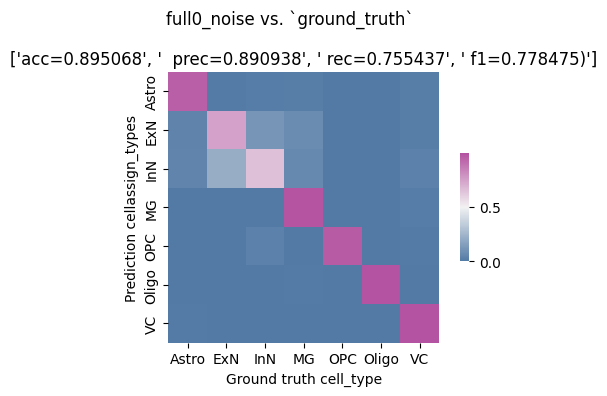

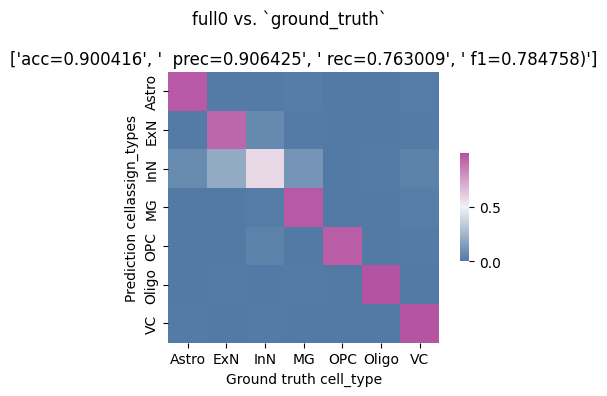

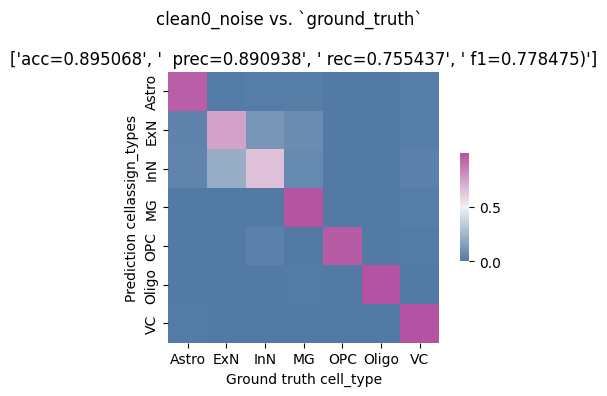

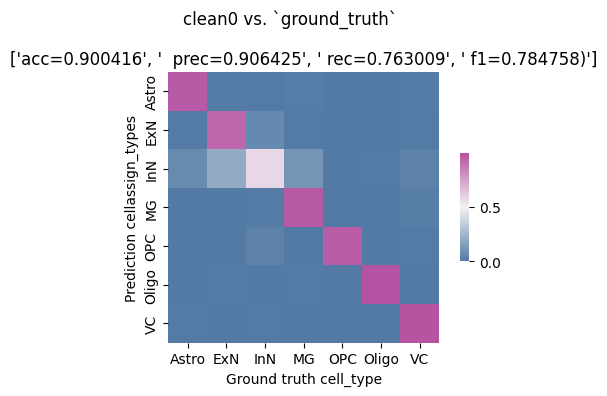

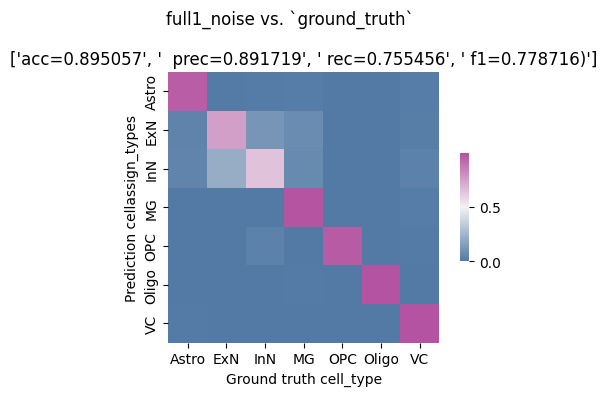

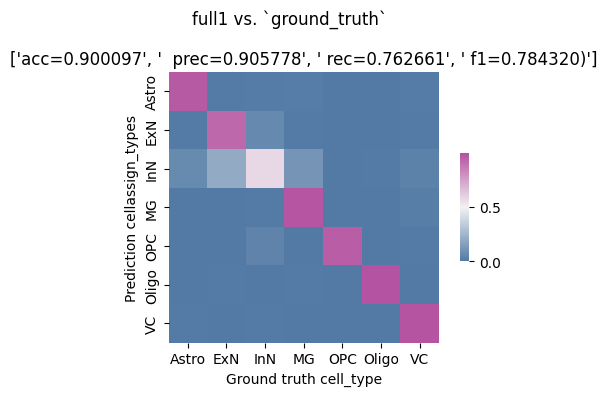

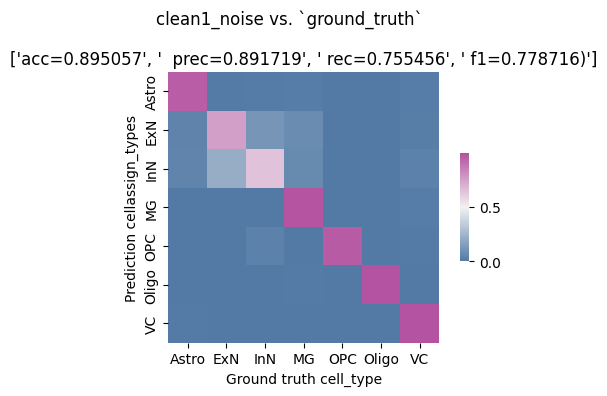

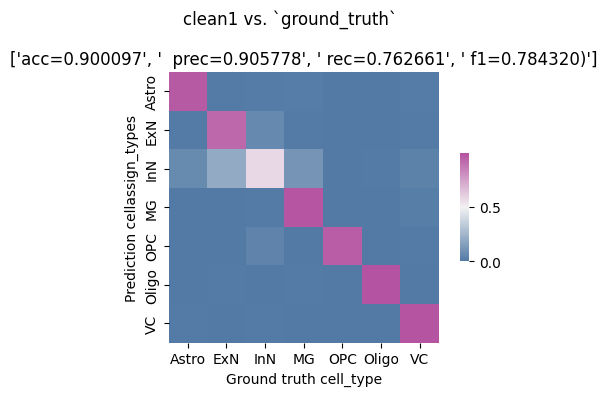

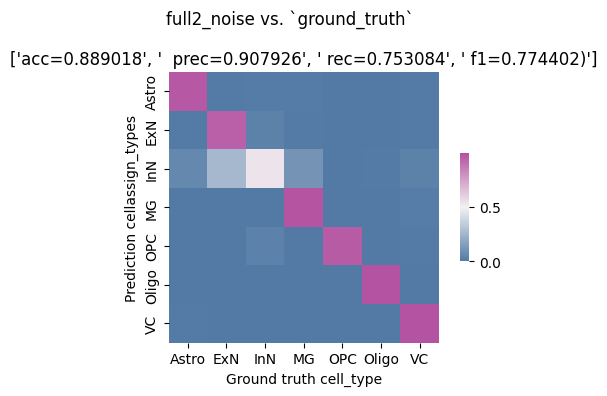

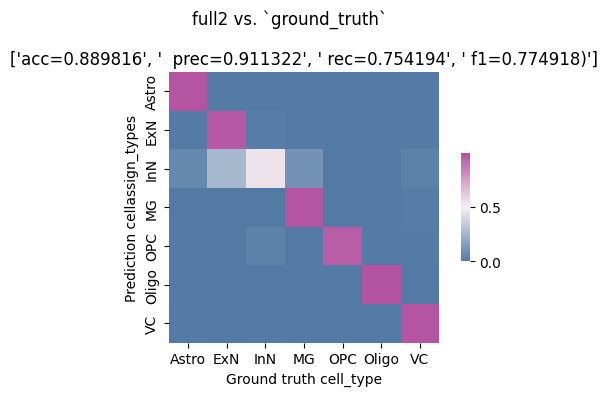

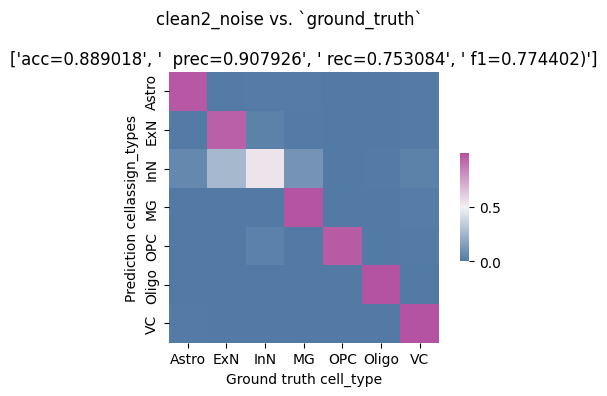

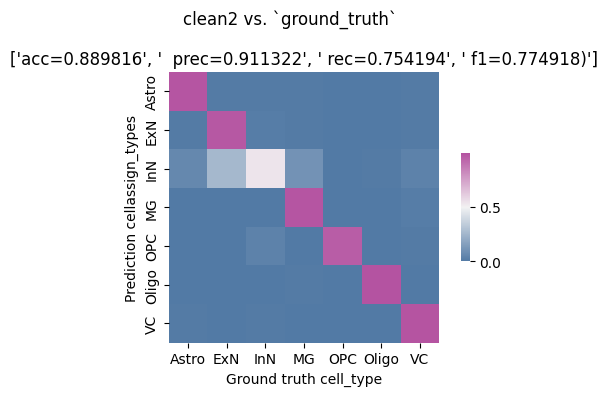

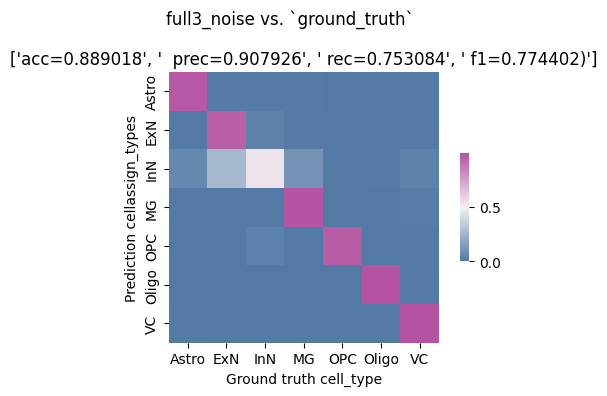

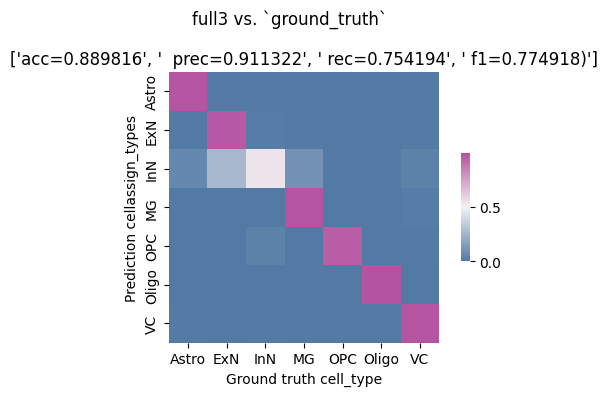

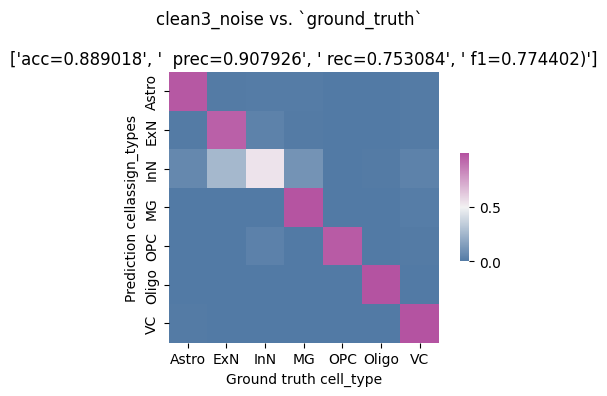

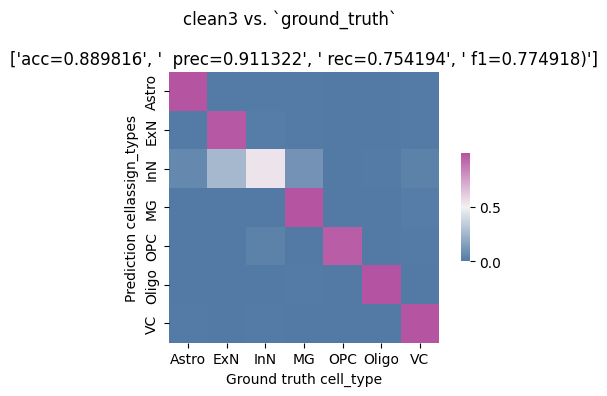

In [11]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 0

for rep in range(4):
    for samp_set in ["full", "clean"]:
        noise = "_noise"
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)


        noise = ""
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        assess_ca_v_ground_truth(predictionsA, 
                        A,     
                        pred_key = "cellassign_types",
                        cell_type_key = "cell_type")

        assess_ca_v_ground_truth(predictionsB, 
                        B,     
                        pred_key = "cellassign_types",
                        cell_type_key = "cell_type")

### Full and Clean sets  vanilla vs. continuous_covariates ("_noise")

In [7]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 1

for samp_set in ["full", "clean"]:
    noise = "_noise"
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    noise = ""
    B = f"{samp_set}{rep}{noise}"
    filenB = root_path / f"testing/{B}_predictions.feather"
    predictionsB = pd.read_feather(filenB)

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
    )
    # print_count_group(predictionsA, predictionsB, labs=[A, B])
    # plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")


    print_count_ground_truth(predictionsA,A)
    plot_confusion(predictionsA, title_caption=f"{A} vs. `ground_truth`", pred_key="cellassign_types_A", cell_type_key="cell_type_A")

    print_count_ground_truth(predictionsB,B)
    plot_confusion(predictionsB, title_caption=f"{B} vs. `ground_truth`", pred_key="cellassign_types_B", cell_type_key="cell_type_B")


 N samples full1_noise= 1072412
           full1_noise  full1_noise_ca  full1_noisepct  full1_noise_capct
cell_type                                                                
Oligo           521554          527606       48.633734          49.198069
ExN             154510          159740       14.407709          14.895395
InN             121286          153888       11.309646          14.349709
Astro           107952           97086       10.066280           9.053051
MG               80846           56606        7.538707           5.278382
OPC              72922           75014        6.799812           6.994886
VC               13342            2472        1.244111           0.230508


KeyError: 'cell_type_A'

In [ ]:
plot_confusion(predictionsA, title_caption=f"{A} vs. `ground_truth`", pred_key="cellassign_types", cell_type_key="cell_type")


In [ ]:
unknowns = predictionsA[predictionsA.cell_type=="UNKNOWN"]
knowns = predictionsA[predictionsA.cell_type!="UNKNOWN"]
100*unknowns.cellassign_types.value_counts()/unknowns.shape[0]
unknowns.shape

In [ ]:

print_count_ground_truth(predictionsB,B)
# plot_confusion(predictionsB, title_caption=f"{B} vs. `ground_truth`", pred_key="cellassign_types_B", cell_type_key="cell_type_B")


In [ ]:
predictionsA

plot_confusion(predictionsA, title_caption=f"{A} vs. `ground_truth`", pred_key="cellassign_types", cell_type_key="cell_type")


#### implications

For the "clean" samples choosing batch correction with continuous covariates (`noise`) doesn't make much of a difference.  However for the "full" set of samples it is crucial.  It seems reasonabl the the "dirty" samples drive this need for more involved batch correction.


### Vanilla and "Noise" sets  Clean vs. Full ("_noise")

 N samples clean3_noise= 1072412, N samples full3_noise= 1072412
   (underscore `_` indicates samples matched to clean3_noise samples)
                  clean3_noisepct  full3_noisepct  full3_noisepct_  \
cellassign_types                                                     
Oligo                   49.192661       49.192661        49.192661   
InN                     19.806287       19.806287        19.806287   
ExN                      9.636502        9.636502         9.636502   
Astro                    8.884645        8.884645         8.884645   
OPC                      7.000574        7.000574         7.000574   
MG                       5.250407        5.250407         5.250407   
VC                       0.228923        0.228923         0.228923   

                  clean3_noise  full3_noise_  
cellassign_types                              
Oligo                   527548        527548  
InN                     212405        212405  
ExN                     103343        103343  

/var/tmp/ipykernel_3967893/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3_noise= 1072412, N samples full3_noise= 1072412
   (underscore `_` indicates samples matched to clean3_noise samples)
                  clean3_noisepct  full3_noisepct  full3_noisepct_  \
cellassign_types                                                     
Oligo                   49.192661       49.192661        49.192661   
InN                     19.806287       19.806287        19.806287   
ExN                      9.636502        9.636502         9.636502   
Astro                    8.884645        8.884645         8.884645   
OPC                      7.000574        7.000574         7.000574   
MG                       5.250407        5.250407         5.250407   
VC                       0.228923        0.228923         0.228923   

                  clean3_noise  full3_noise_  
cellassign_types                              
Oligo                   527548        527548  
InN                     212405        212405  
ExN                     103343        103343  

/var/tmp/ipykernel_3967893/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3= 1072412, N samples full3= 1072412
   (underscore `_` indicates samples matched to clean3 samples)
                  clean3pct   full3pct  full3pct_  clean3  full3_
cellassign_types                                                 
Oligo             49.207674  49.207674  49.207674  527709  527709
InN               20.199140  20.199140  20.199140  216618  216618
ExN                9.241691   9.241691   9.241691   99109   99109
Astro              8.814616   8.814616   8.814616   94529   94529
OPC                7.037967   7.037967   7.037967   75476   75476
MG                 5.271761   5.271761   5.271761   56535   56535
VC                 0.227152   0.227152   0.227152    2436    2436


/var/tmp/ipykernel_3967893/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3= 1072412, N samples full3= 1072412
   (underscore `_` indicates samples matched to clean3 samples)
                  clean3pct   full3pct  full3pct_  clean3  full3_
cellassign_types                                                 
Oligo             49.207674  49.207674  49.207674  527709  527709
InN               20.199140  20.199140  20.199140  216618  216618
ExN                9.241691   9.241691   9.241691   99109   99109
Astro              8.814616   8.814616   8.814616   94529   94529
OPC                7.037967   7.037967   7.037967   75476   75476
MG                 5.271761   5.271761   5.271761   56535   56535
VC                 0.227152   0.227152   0.227152    2436    2436


/var/tmp/ipykernel_3967893/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


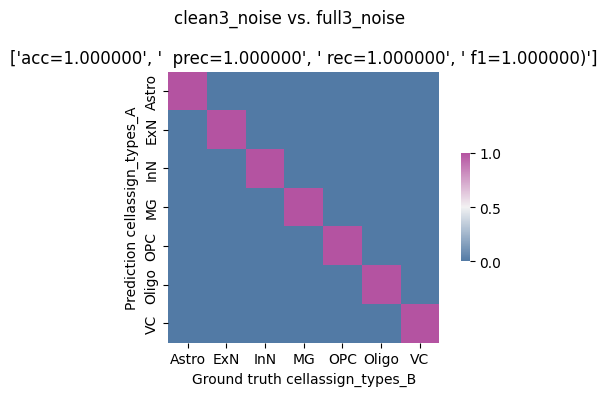

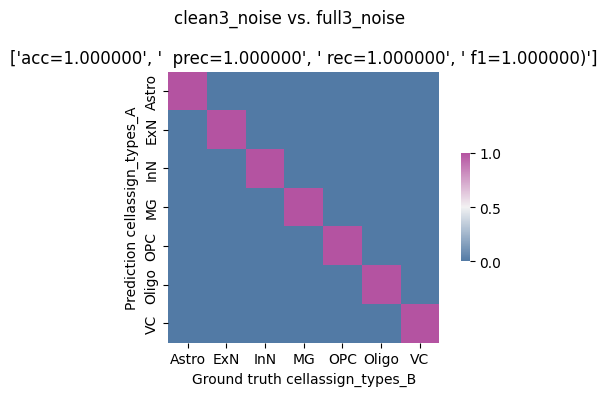

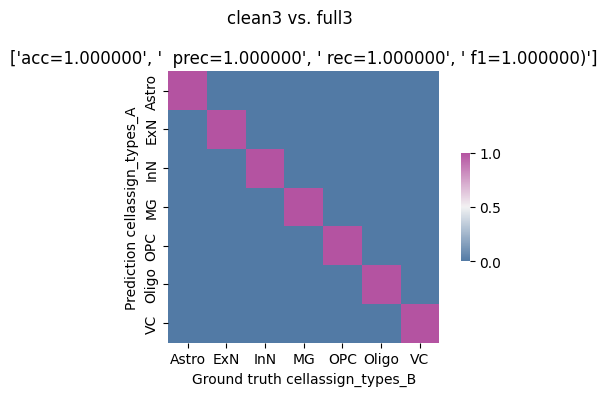

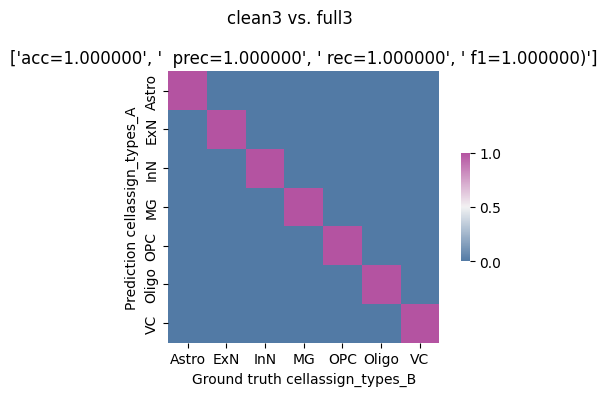

In [8]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 3

for noise in ["_noise", ""]:
    samp_set = "clean"
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    samp_set = "full"
    B = f"{samp_set}{rep}{noise}"
    filenB = root_path / f"testing/{B}_predictions.feather"
    predictionsB = pd.read_feather(filenB)

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="left", suffixes=("_A", "_B")
    )
    print_count_subset(predictionsA, predictionsB, labs=[A, B])
    plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

    print_count_subset(predictionsA, predictionsB, labs=[A, B])
    plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")



#### implications

_Without_ the `noise` batch correction the full dataset (presumably driven by the "dirty" samples) classify many of the neurons as "fibrous_astrocytes" and there is very poor correspondence between the "clean" samples when fit _with_ the "dirty" samples versus alone.  However _with_ batch correction including continuous `noise` covariates (`["doublet_score", "pct_counts_mt", "pct_counts_rb"]` ) the cell type assignments are overal quite accurate between the two datasets.   The notable exception are the "unknown", "t_cell" and "b_cell" assigned cells.  However these represent extremely rare cell types according to this dataset and assignment.

## conclusions

For "ground truth" assignments fitting cellassign with the continusous `noise` covariates on the "full" dataset should give us the most reasonable ground truth. 

Next steps:
- consider further simplified 
- consider alternate ground truth assignment methods which might leverage additional priors.  Here we are only constrained by consistency and the assumed marker genes
- estimate baseline performance of this ground truth designation procedure by analyzing the stability of assignments with different seed values. 

## repeatability...

In [9]:
# full nooise, clean noise, clean naive
# compare seed 0 and seed 1

for samp_set in ["full", "clean"]:
    for noise in ["_noise", ""]:
        if samp_set == "full" and noise == "":
            continue
        rep = 3
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        rep = 4
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/ergonyc/labelator/testing/full4_noise_predictions.feather'

### results

Seems to be some great confusion between immune cells:  microglia, t_cell, b_cell, for the clean dataset without the noise parameters.



In [ ]:
# full nooise, clean noise, clean naive
# compare seed 0 and seed 1

for samp_set in ["full", "clean"]:
    for noise in ["_noise", ""]:
        if samp_set == "full" and noise == "":
            continue
        rep = 3
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        rep = 4
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

In [ ]:
samp_set = "full"
noise = "_noise"

rep = 0

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)
    for rep2 in range(4):
        if rep == rep2:
            continue
        else:
            B = f"{samp_set}{rep2}{noise}"
            filenB = root_path / f"testing/{B}_predictions.feather"
            predictionsB = pd.read_feather(filenB)
            merged_predictions = pd.merge(
                predictionsA,
                predictionsB,
                on="cell",
                how="right",
                suffixes=("_A", "_B"),
            )
            print_count_group(predictionsA, predictionsB, labs=[A, B])
            plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

In [ ]:
samp_set = "full"
noise = "_noise"

rep = 0
summary = pd.DataFrame()
summary_pct = pd.DataFrame()

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    summary_pct[A] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    summary[A] = predictionsA.cellassign_types.value_counts()


print(f"counts 0-3")
print(summary)
print(f"pcts 0-3")
print(summary_pct)

In [ ]:
samp_set = "clean"
noise = "_noise"

rep = 0

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)
    for rep2 in range(4):
        if rep == rep2:
            continue
        else:
            B = f"{samp_set}{rep2}{noise}"
            filenB = root_path / f"testing/{B}_predictions.feather"
            predictionsB = pd.read_feather(filenB)
            merged_predictions = pd.merge(
                predictionsA,
                predictionsB,
                on="cell",
                how="right",
                suffixes=("_A", "_B"),
            )
            print_count_group(predictionsA, predictionsB, labs=[A, B])
            plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

In [ ]:
samp_set = "clean"
noise = "_noise"

rep = 0
summary = pd.DataFrame()
summary_pct = pd.DataFrame()

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    summary_pct[A] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    summary[A] = predictionsA.cellassign_types.value_counts()


print(f"counts 0-3")
print(summary)
print(f"pcts 0-3")
print(summary_pct)

In [ ]:
predictionsA

In [ ]:
preds

In [ ]:
predictions

In [ ]:
def get_stats_from_probs(predictions: pd.DataFrame, cell_types: list) -> pd.DataFrame:
    """
    Get probabilities, entropy, log entropy, labels, and margin of probability.
    """
    # Applying softmax to convert logits to probabilities
    probabilities = predictions[cell_types].values

    # Calculate entropy
    entropy = -np.sum(probabilities * np.log(probabilities), axis=1)

    # n_classes = probabilities.shape[1]
    logents = entropy.log().numpy()

    # print("Logits: ", logs)
    # print("Probabilities: ", probs)

    maxprobs = probabilities.max(axis=1)

    # Binarize the true labels for each class
    from sklearn.preprocessing import label_binarize

    labels = label_binarize(y_true, classes=np.arange(len(cell_types)))

    labels = categories[probabilities.argmax(axis=1)]

    margin = calculate_margin_of_probability(probabilities)

    return {
        "logit": logs,
        "prob": probs,
        "entropy": ents,
        "logE": logents,
        "max_p": maxprobs,
        "mop": margin,
        "label": labels,
    }


def calculate_margin_of_probability(probabilities: torch.Tensor) -> np.ndarray:
    """
    Calculate the margin of probability.

    Parameters
    ----------
    probabilities : torch.Tensor
        Probabilities from a model.

    Returns
    -------
    np.ndarray
        Array of margin of probability.
    """
    # Get the top two probabilities
    top_probs, _ = torch.topk(probabilities, 2)

    # Calculate the margin
    margin = top_probs[:, 0] - top_probs[:, 1]
    return margin.numpy()

In [ ]:
ground_truth = pd.read_csv(
    Path.cwd().parent / "data/scdata/xylena_raw/cell_barcode_labels.csv", index_col=0
)

In [ ]:
ground_truth.head()

In [ ]:
ground_truth.shape

In [ ]:
ground_truth.cell_type.value_counts()

In [ ]:
100 * ground_truth.cell_type.value_counts() / ground_truth.shape[0]

In [ ]:
ground_truth.sample.value_counts()

In [ ]:
ground_truth["sample"].value_counts()

In [ ]:
adata.obs._cell_type.value_counts()

In [ ]:
filen = Path.cwd().parent / "data/scdata/xylena_raw/brain_atlas_anndata.h5ad"
adata = ad.read_h5ad(filen)

In [ ]:
adata

In [ ]:
adata.obs.cell_type.value_counts()

In [ ]:
filen = Path.cwd().parent / "data/scdata/xylena_raw/brain_atlas_anndata.h5ad"
adata = ad.read_h5ad(filen)

In [ ]:
adata

In [ ]:
adata.obs.cell_type.value_counts()

In [ ]:
100 * adata.obs.cell_type.value_counts() / adata.shape[0]

In [ ]:
adata.head()

In [ ]:
adata.obs.head()

In [ ]:
adata.obs["sample"].value_counts()

In [ ]:
adata.shape

In [ ]:
adata

In [ ]:
ground_truth = pd.read_csv(
    Path.cwd().parent / "data/scdata/xylena_raw/cellassign_predictions_feb13.csv",
    index_col=0,
)

In [ ]:
ground_truth.head()

In [ ]:
adata
